In [65]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import graphlab as gl
import seaborn as sns
import scipy
import scipy.stats as sts
import sklearn

from sklearn.linear_model import LinearRegression, LogisticRegression

from networkx.algorithms import community
%matplotlib inline

In [66]:
PATH_RATINGS = "data/ratings.csv"
PATH_GENDER = "data/gender.csv"

# 17359346 ratings/edges
ratings = pd.read_csv(PATH_RATINGS, names=['user_id', 'profile_id', 'rating'])
# 220970 genders/nodes
gender = pd.read_csv(PATH_GENDER, names=['user_id', 'gender'])

In [67]:
degrees = pd.Series(ratings.groupby('user_id')['profile_id'].nunique(), name="degree")

df = pd.merge(ratings, gender, how="left", on="user_id", right_index=False)
#df = pd.merge(df, degrees, on='user_id', right_index=False)
df = pd.merge(df, gender, how="left", left_on="profile_id", right_on="user_id", right_index=False).drop("user_id_y", axis=1)

In [68]:
df = df.rename(columns={
    "user_id_x": "source",
    "profile_id": "target",
    "rating": "weight",
    "gender_x": "source_gender",
    "gender_y": "target_gender"
})
df.head()

,source,target,weight,source_gender,target_gender
0,1,133,8,F,M
1,1,720,6,F,F
2,1,971,10,F,M
3,1,1095,7,F,M
4,1,1616,10,F,M


In [69]:
# Remove all the edges which link to nodes that have no outgoing edges
# 12044685 edges
df_pruned = df[df["target"].isin(df["source"])]

In [70]:
df_by_target = df.groupby(by=["target"])
df_stats_in = df_by_target.agg({'weight' : 'mean', "source": "nunique"})
df_stats_in = df_stats_in.reset_index()
df_stats_in = df_stats_in.rename(columns={
    "weight": "received_rating_mean",
    "source": "indegree",
    "target": "user_id"
})
# 168791 rows
df_stats_in.head()

,user_id,indegree,received_rating_mean
0,1,22,5.272727
1,2,213,7.150235
2,4,1,1.000000
3,8,4,7.500000
4,9,22,9.454545


In [71]:
df_by_source = df.groupby(by=["source"])
df_stats_out = df_by_source.agg({'weight' : 'mean', "source_gender": "first", "target": "nunique"})
df_stats_out = df_stats_out.reset_index()
df_stats_out = df_stats_out.rename(columns={
    "source": "user_id",
    "weight": "rating_mean",
    "source_gender": "gender",
    "target": "outdegree"
})
# 135359 rows
df_stats_out.head()

,user_id,gender,outdegree,rating_mean
0,1,F,345,6.510145
1,2,F,97,8.041237
2,3,U,20,7.150000
3,4,F,101,6.841584
4,5,F,105,8.419048


In [72]:
df_stats_all = pd.merge(df_stats_out, df_stats_in, how="left", on="user_id")
df_stats = df_stats_all.dropna()
# 83180 rows
df_stats.head()

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean
0,1,F,345,6.510145,22.0,5.272727
1,2,F,97,8.041237,213.0,7.150235
3,4,F,101,6.841584,1.0,1.000000
7,8,M,21,6.380952,4.0,7.500000
8,9,M,3521,5.856007,22.0,9.454545


# Saving and loading the data

In [7]:
df_pruned.to_csv("data/df_edges_pruned.csv", index=False)

In [122]:
df.to_csv("data/df_graphlab_edges.csv", index=False)
df_pruned.to_csv("data/df_graphlab_edges.csv", index=False)
df_stats.to_csv("data/df_stats.csv", index=False)

In [17]:
#df = pd.read_csv("data/df_graphlab_edges.csv")
df_stats = pd.read_csv("data/df_stats.csv")

In [2]:
df_pruned = pd.read_csv("data/df_edges_pruned.csv")

In [9]:
df_by_source = df.groupby(by=["source"])
df_stats_out = df_by_source.agg({'weight' : 'mean', "source_gender": "first", "target": "nunique"})
df_stats_out = df_stats_out.reset_index()
df_stats_out = df_stats_out.rename(columns={
    "source": "user_id",
    "weight": "rating_mean",
    "source_gender": "gender",
    "target": "outdegree"
})
df_stats_out.head()

,user_id,gender,outdegree,rating_mean
0,1,F,345,6.510145
1,2,F,97,8.041237
2,3,U,20,7.150000
3,4,F,101,6.841584
4,5,F,105,8.419048


# Fit logistic regression with rating mean, degree to gender

In [17]:
X = np.array([df_stats['outdegree'], df_stats['indegree'], df_stats['rating_mean'], df_stats['received_rating_mean']]).T
y = df_stats['gender']

logreg_m = sklearn.linear_model.LogisticRegression()
logreg_m.fit(X, y)

print('Intercept: \n', logreg_m.intercept_)
print('Coefficients: \n', logreg_m.coef_)

/Users/teemu/.virtualenvs/graphlab/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/teemu/.virtualenvs/graphlab/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


('Intercept: \n', array([-4.76598588,  4.76058211, -3.07926298]))
('Coefficients: \n', array([[ 3.00682054e-03, -5.94117923e-04,  9.46953388e-01,
        -1.92069798e-01],
       [-3.01233343e-03,  5.96375850e-04, -9.46631141e-01,
         1.92421019e-01],
       [ 1.17821268e-04, -2.01460789e-02, -4.32527764e-01,
        -3.37464156e-01]]))


In [18]:
logreg_m.score(X, y)

0.7470545804279874

In [22]:
df_samp = df_stats.sample(1000)
X = np.array([df_samp['outdegree'], df_samp['indegree'], df_samp['rating_mean'], df_samp['received_rating_mean']]).T

In [15]:
X = np.array([df['weight'], df['degree']]).T
y = df['source_gender']

logr_weight_gender = sklearn.linear_model.LogisticRegression()
logr_weight_gender.fit(X, y)

print('Intercept: \n', logr_weight_gender.intercept_)
print('Coefficients: \n', logr_weight_gender.coef_)

KeyboardInterrupt: 

In [31]:
logr_weight_gender.score(arr.T, df['source_gender'])

0.622376154032531

# Fit linear regression with rating mean to degree

Linear regression models of rating (1-10) as a response to degree. So does users with more ratings (higher degree) rate others higher or lower.

It seems that females with fewer ratings rated people higher (and viceversa 

In [16]:
def get_corrcoef(df):
    mat = np.array([df['outdegree'], df['indegree'], df['rating_mean'], df['received_rating_mean']])
    return np.corrcoef(mat)

In [17]:
print(get_corrcoef(df_stats))

[[ 1.          0.03364214 -0.03474313 -0.01301755]
 [ 0.03364214  1.         -0.00595596 -0.01555257]
 [-0.03474313 -0.00595596  1.          0.10186237]
 [-0.01301755 -0.01555257  0.10186237  1.        ]]


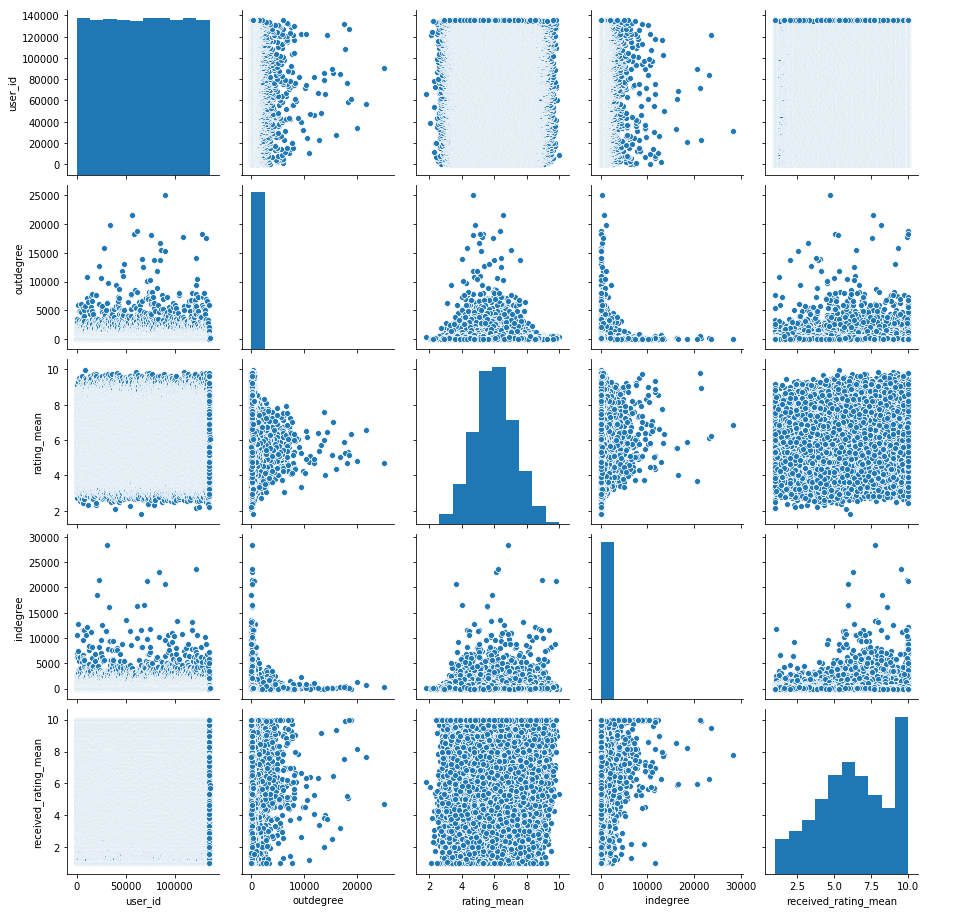

In [18]:
sb = sns.pairplot(df_stats)

In [19]:
sts.linregress(df_stats['outdegree'], df_stats['indegree'])

LinregressResult(slope=0.03785423609911538, intercept=139.03762784394138, rvalue=0.03364213624597047, pvalue=2.8620332323102716e-22, stderr=0.0038992472937635046)

In [20]:
sts.linregress(df_stats['rating_mean'], df_stats['received_rating_mean'])

LinregressResult(slope=0.20660840123667712, intercept=5.110535047659664, rvalue=0.10186237005547213, pvalue=1.1102403344072891e-190, stderr=0.006996246226467251)

In [14]:
sts.linregress(df_stats['received_rating_mean'], df_stats['outdegree'])

LinregressResult(slope=-2.3159413964589013, intercept=167.0090195701931, rvalue=-0.013017553060418937, pvalue=0.00017369636180541707, stderr=0.6168181892650493)

In [15]:
sts.linregress(df_stats['received_rating_mean'], df_stats['indegree'])

LinregressResult(slope=-3.1133742065280345, intercept=164.582412819782, rvalue=-0.015552571006214351, pvalue=7.267083991753656e-06, stderr=0.6940206024978034)

In [73]:
def by_gender(df, gender):
    return df[df['gender'] == gender]
    
def linreg(df):
    return sts.linregress(df['rating_mean'], df['indegree'])

sfemale = by_gender(df_stats_all, 'F')
smale = by_gender(df_stats_all, 'M')
sunknown = by_gender(df_stats_all, 'U')

lr_all = linreg(df_stats_all)
lr_sfemale = linreg(sfemale)
lr_smale = linreg(smale)
lr_sunknown = linreg(sunknown)

In [74]:
print('all correlation coefficient')
print(np.corrcoef(df_stats_all['rating_mean'], df_stats_all['outdegree']))
print('female correlation coefficient')
print(np.corrcoef(sfemale['rating_mean'], sfemale['outdegree']))
print('male correlation coefficient')
print(np.corrcoef(smale['rating_mean'], smale['outdegree']))
print('unknown correlation coefficient')
print(np.corrcoef(sunknown['rating_mean'], sunknown['outdegree']))

all correlation coefficient
[[ 1.         -0.01963155]
 [-0.01963155  1.        ]]
female correlation coefficient
[[ 1.         -0.07814598]
 [-0.07814598  1.        ]]
male correlation coefficient
[[ 1.         -0.10478414]
 [-0.10478414  1.        ]]
unknown correlation coefficient
[[ 1.         -0.03172363]
 [-0.03172363  1.        ]]


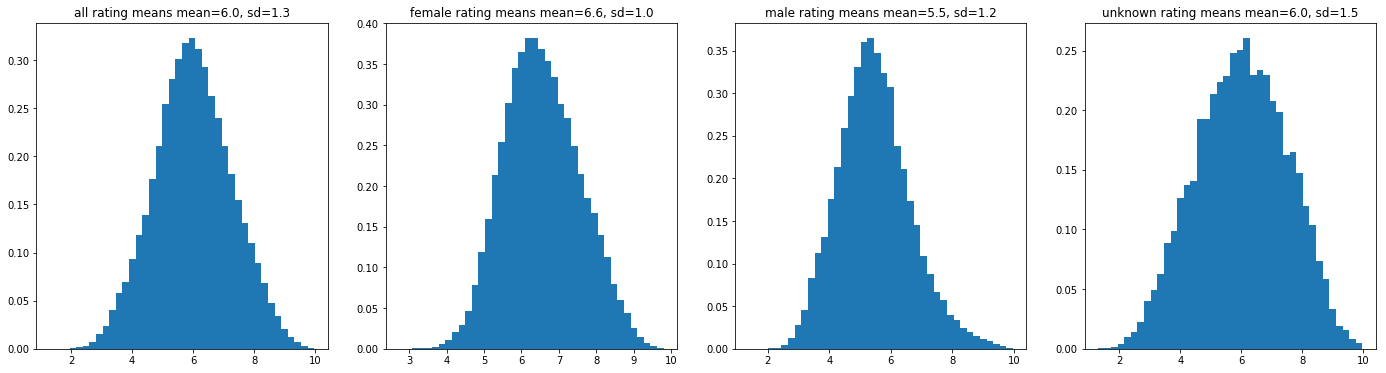

In [75]:
def plot_hist(ax, df, name):
    ax.hist(df['rating_mean'], density=True, bins=40)
    ax.set_title("{} mean={}, sd={}".format(name, np.round(df['rating_mean'].mean(), 1), np.round(df['rating_mean'].std(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats_all, "all rating means")
plot_hist(ax[1], sfemale, "female rating means")
plot_hist(ax[2], smale, 'male rating means')
plot_hist(ax[3], sunknown, 'unknown rating means')

In [50]:
df_female[df_female['rating_mean'] > 9]

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean
1383,1384,F,20,9.300000,3.0,7.000000
1534,1535,F,21,9.285714,304.0,2.263158
3075,3076,F,115,9.121739,1440.0,9.966667
4401,4402,F,157,9.159236,153.0,5.843137
5416,5417,F,29,9.103448,9.0,8.888889
5922,5923,F,147,9.238095,2.0,10.000000
6145,6146,F,395,9.296203,234.0,9.581197
6851,6852,F,149,9.335570,50.0,6.980000
7718,7719,F,78,9.358974,31.0,7.774194
8103,8104,F,174,9.298851,130.0,4.276923


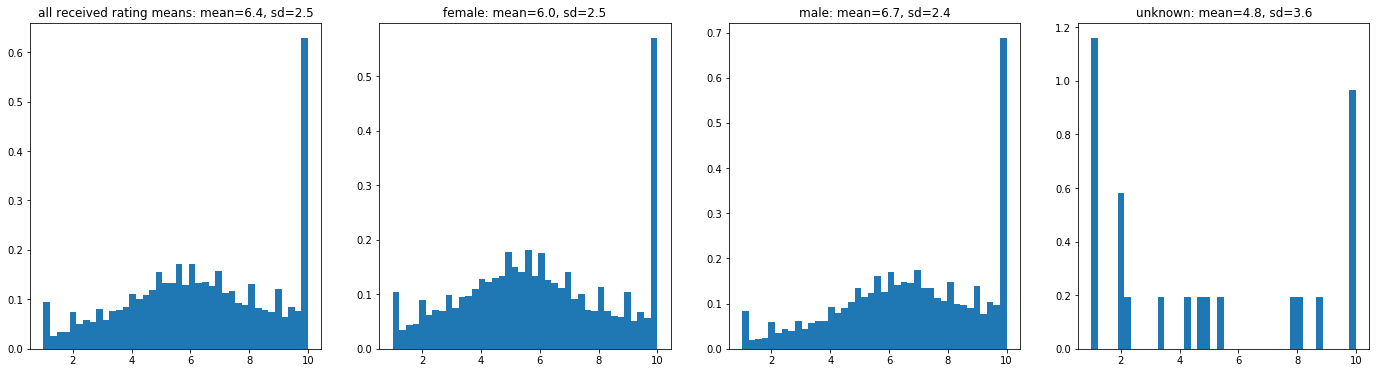

In [76]:
def plot_hist(ax, df, name):
    ax.hist(df['received_rating_mean'], density=True, bins=40)
    ax.set_title("{}: mean={}, sd={}".format(name, np.round(df['received_rating_mean'].mean(), 1), np.round(df['received_rating_mean'].std(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all received rating means")
plot_hist(ax[1], by_gender(df_stats, 'F'), "female")
plot_hist(ax[2], by_gender(df_stats, 'M'), "male")
plot_hist(ax[3], by_gender(df_stats, 'U'), "unknown")

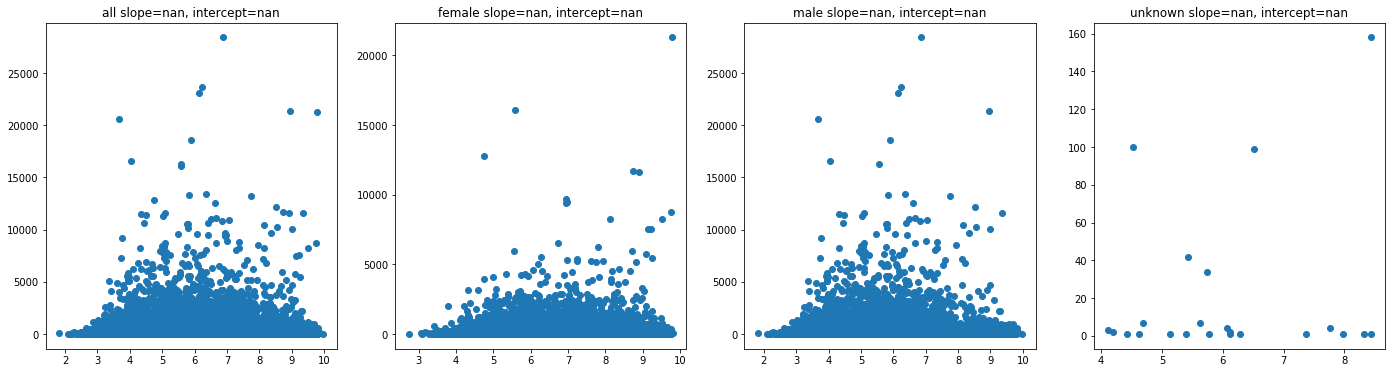

In [63]:
t = np.linspace(1, 10, 100)

def plot_linreg(ax, df, lr_df, name):
    ax.scatter(df['rating_mean'], df['indegree'])
    ax.plot(t, t * lr_df[0] + lr_df[1])
    ax.set_title("{} slope={}, intercept={}".format(name, np.round(lr_df[0], 2), np.round(lr_df[1], 2)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_linreg(ax[0], df_stats_all, lr_all, "all")
plot_linreg(ax[1], sfemale, lr_sfemale, "female")
plot_linreg(ax[2], smale, lr_smale, 'male')
plot_linreg(ax[3], sunknown, lr_sunknown, 'unknown')

In [64]:
def linreg(df):
    return sts.linregress(df['weight'], df['degree'])

sfemale = df[df['source_gender'] == 'F'].sample(10000)
smale = df[df['source_gender'] == 'M'].sample(10000)
tfemale = df[df['source_gender'] == 'F'].sample(10000)
tmale = df[df['source_gender'] == 'M'].sample(10000)

lr_sfemale = linreg(sfemale)
lr_smale = linreg(smale)
lr_tfemale = linreg(tfemale)
lr_tmale = linreg(tmale)

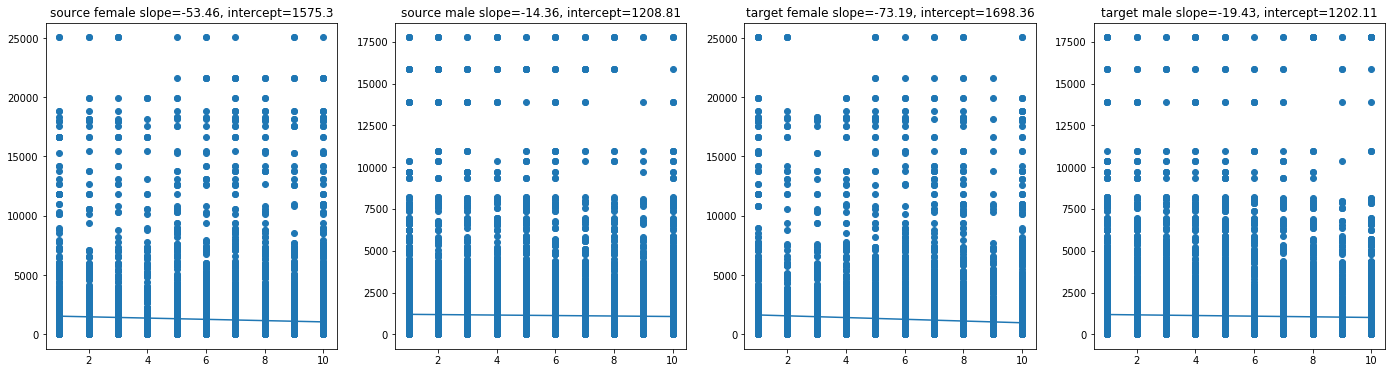

In [66]:
t = np.linspace(1, 10, 100)

def plot_linreg(ax, df, lr_df, name):
    ax.scatter(df['weight'], df['degree'])
    ax.plot(t, t * lr_df[0] + lr_df[1])
    ax.set_title("{} slope={}, intercept={}".format(name, np.round(lr_df[0], 2), np.round(lr_df[1], 2)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_linreg(ax[0], sfemale, lr_sfemale, "source female")
plot_linreg(ax[1], smale, lr_smale, 'source male')
plot_linreg(ax[2], tfemale, lr_tfemale, 'target female')
plot_linreg(ax[3], tmale, lr_tmale, 'target male')

# Group by mean rating

In [68]:
df_mean_low = df_stats[df_stats['rating_mean'] < 4]
df_mean_avg = df_stats[(df_stats['rating_mean'] > 4) & (df_stats['rating_mean'] < 6)]
df_mean_high = df_stats[df_stats['rating_mean'] > 6]

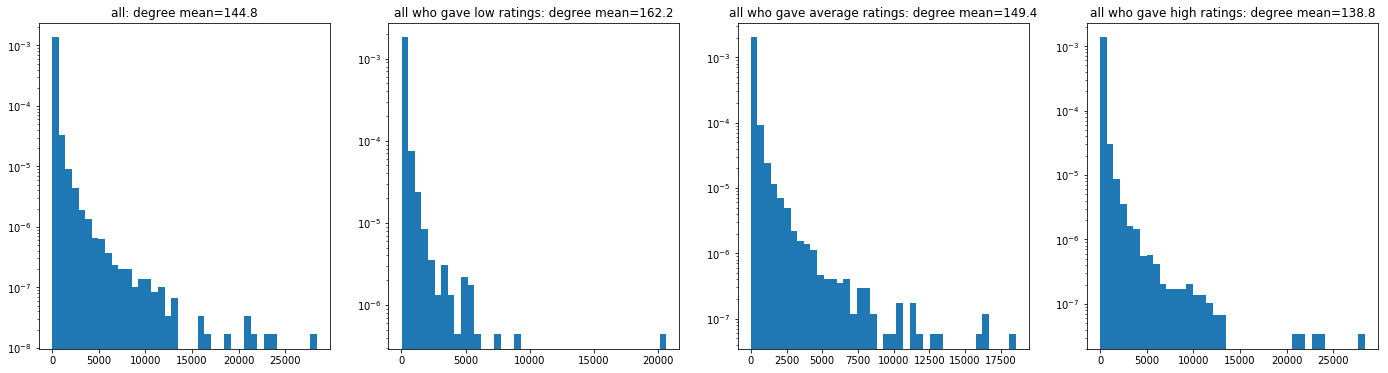

In [71]:
def plot_hist(ax, df, name):
    ax.hist(df['indegree'], density=True, log=True, bins=40)
    ax.set_title("{}: indegree mean={}".format(name, np.round(df['indegree'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_mean_low, "all who gave low ratings")
plot_hist(ax[2], df_mean_avg, "all who gave average ratings")
plot_hist(ax[3], df_mean_high, "all who gave high ratings")

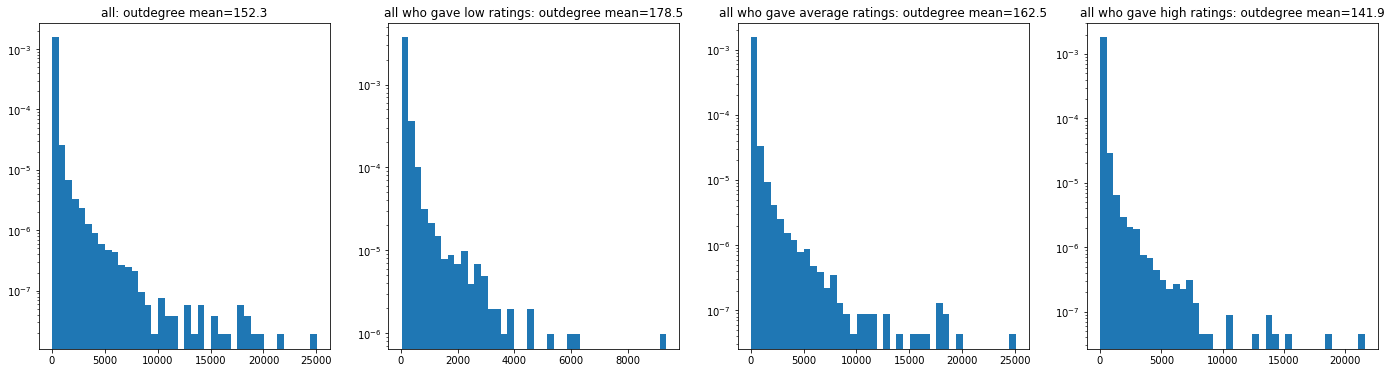

In [72]:
def plot_hist(ax, df, name):
    ax.hist(df['outdegree'], density=True, log=True, bins=40)
    ax.set_title("{}: outdegree mean={}".format(name, np.round(df['outdegree'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_mean_low, "all who gave low ratings")
plot_hist(ax[2], df_mean_avg, "all who gave average ratings")
plot_hist(ax[3], df_mean_high, "all who gave high ratings")

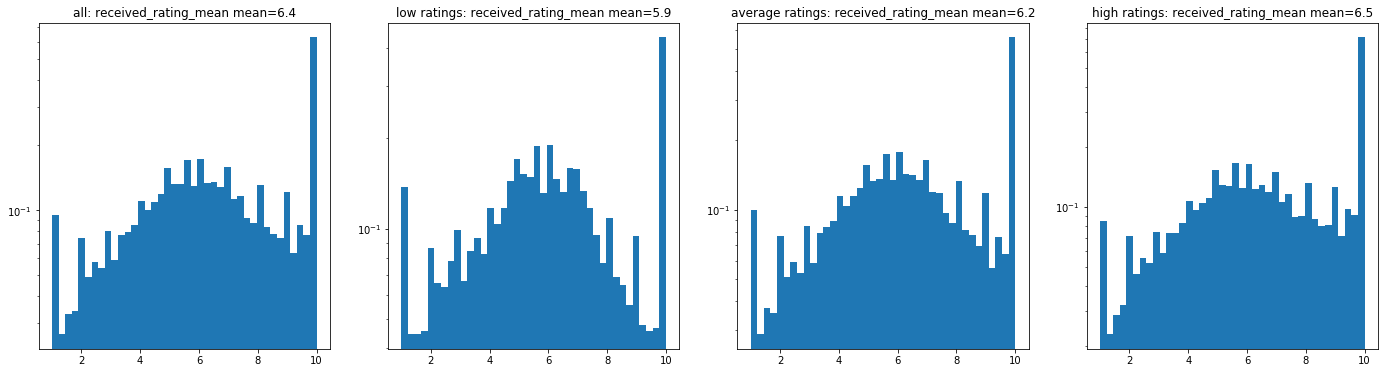

In [74]:
def plot_hist(ax, df, name):
    ax.hist(df['received_rating_mean'], density=True, log=True, bins=40)
    ax.set_title("{}: received_rating_mean mean={}".format(name, np.round(df['received_rating_mean'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_mean_low, "low ratings")
plot_hist(ax[2], df_mean_avg, "average ratings")
plot_hist(ax[3], df_mean_high, "high ratings")

# Low, mid and top quantiles with in/out degrees

In [84]:
q = df_stats['outdegree'].quantile([0.25, 0.75]).values

df_out_low = df_stats[df_stats['outdegree'] <= q[0]]
df_out_avg = df_stats[(df_stats['outdegree'] > q[0]) & (df_stats['outdegree'] < q[1])]
df_out_high = df_stats[df_stats['outdegree'] >= q[1]]

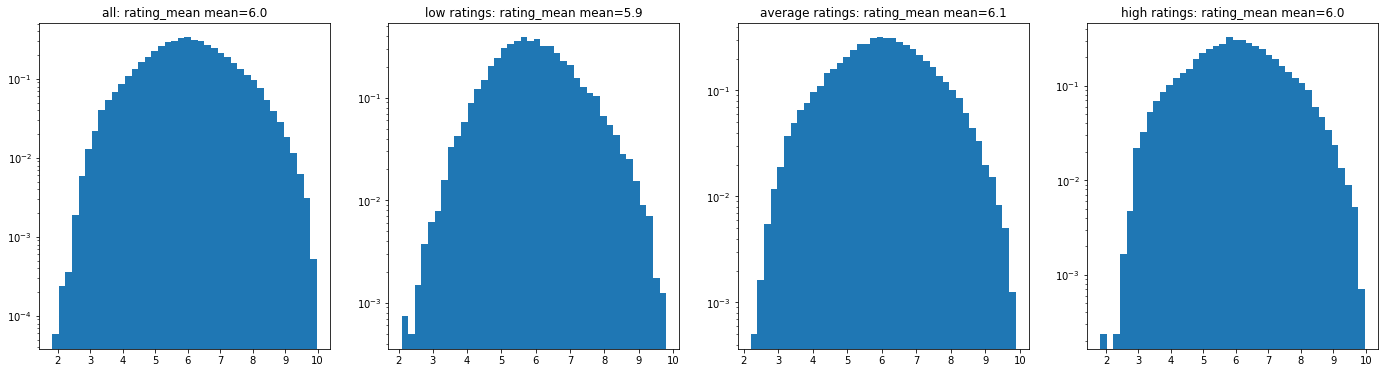

In [86]:
def plot_hist(ax, df, name):
    ax.hist(df['rating_mean'], density=True, log=True, bins=40)
    ax.set_title("{}: rating_mean mean={}".format(name, np.round(df['rating_mean'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_out_low, "low ratings")
plot_hist(ax[2], df_out_avg, "average ratings")
plot_hist(ax[3], df_out_high, "high ratings")

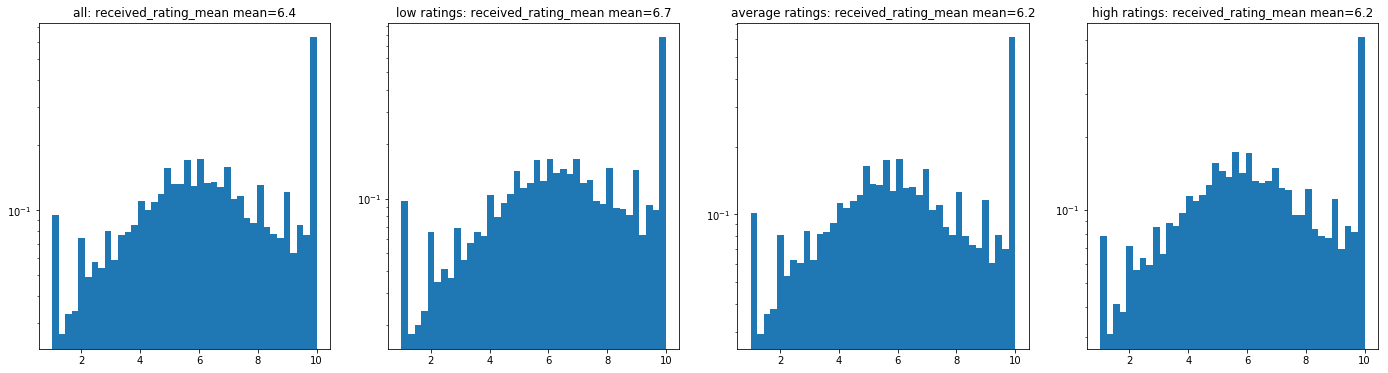

In [85]:
def plot_hist(ax, df, name):
    ax.hist(df['received_rating_mean'], density=True, log=True, bins=40)
    ax.set_title("{}: received_rating_mean mean={}".format(name, np.round(df['received_rating_mean'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_out_low, "low ratings")
plot_hist(ax[2], df_out_avg, "average ratings")
plot_hist(ax[3], df_out_high, "high ratings")

In [88]:
q = df_stats['indegree'].quantile([0.25, 0.75]).values

df_in_low = df_stats[df_stats['indegree'] <= q[0]]
df_in_avg = df_stats[(df_stats['indegree'] > q[0]) & (df_stats['indegree'] < q[1])]
df_in_high = df_stats[df_stats['indegree'] >= q[1]]

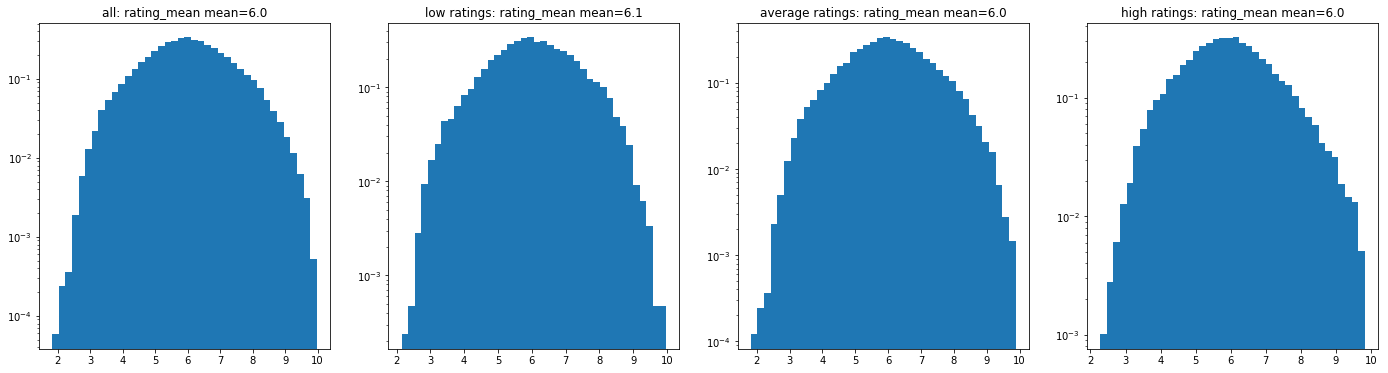

In [89]:
def plot_hist(ax, df, name):
    ax.hist(df['rating_mean'], density=True, log=True, bins=40)
    ax.set_title("{}: rating_mean mean={}".format(name, np.round(df['rating_mean'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_in_low, "low ratings")
plot_hist(ax[2], df_in_avg, "average ratings")
plot_hist(ax[3], df_in_high, "high ratings")

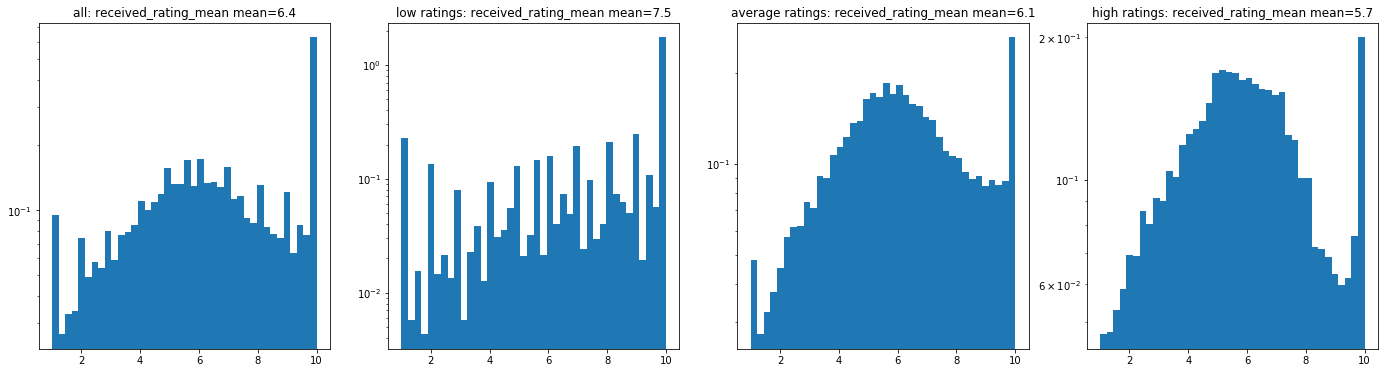

In [90]:
def plot_hist(ax, df, name):
    ax.hist(df['received_rating_mean'], density=True, log=True, bins=40)
    ax.set_title("{}: received_rating_mean mean={}".format(name, np.round(df['received_rating_mean'].mean(), 1)))

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(24, 6)

plot_hist(ax[0], df_stats, "all")
plot_hist(ax[1], df_in_low, "low ratings")
plot_hist(ax[2], df_in_avg, "average ratings")
plot_hist(ax[3], df_in_high, "high ratings")

# Fit linear regression to indegree and received ratings

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

m = np.array([
    [1, 1, 1, 1, 0],
    [1, 1, 0, 0, 1],
    [1, 0, 1, 1, 0],
    [1, 0, 0, 1, 1],
    [0, 1, 0, 1, 1]
])

np.around(cosine_similarity(m), decimals=8)

array([[1.        , 0.57735027, 0.8660254 , 0.57735027, 0.57735027],
       [0.57735027, 1.        , 0.33333333, 0.66666667, 0.66666667],
       [0.8660254 , 0.33333333, 1.        , 0.66666667, 0.33333333],
       [0.57735027, 0.66666667, 0.66666667, 1.        , 0.66666667],
       [0.57735027, 0.66666667, 0.33333333, 0.66666667, 1.        ]])

In [25]:
df_h = df_stats[df_stats['received_rating_mean'] > 9.5]

In [38]:
df_h.sort_values("indegree", ascending=False, kind="mergesort").sort_values("received_rating_mean", ascending=False, kind="mergesort")

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean
117774,117775,M,59,5.118644,7891.0,10.000000
106134,106135,F,132,9.053030,1579.0,10.000000
17682,17683,M,55,7.345455,1505.0,10.000000
48473,48474,M,57,5.666667,1252.0,10.000000
20372,20373,M,24,6.791667,1061.0,10.000000
59337,59338,M,57,5.368421,1011.0,10.000000
27092,27093,F,99,8.585859,1001.0,10.000000
36423,36424,M,26,8.269231,919.0,10.000000
129338,129339,F,205,5.990244,906.0,10.000000
86909,86910,F,372,7.540323,865.0,10.000000


# Adjancency matrix similarity

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.cluster import DBSCAN
from scipy.sparse import csgraph

arr = df_pruned.sample(1000)
src = arr["source"].values
trg = arr["target"].values
wgt = arr["weight"].values

In [18]:
coo = sparse.coo_matrix((wgt, (src, trg)))
csr = coo.tocsr()

sim_mat = cosine_similarity(csr)
#dist_mat = np.subtract(np.ones(sim_mat.shape, dtype=np.int8), sim_mat)

In [19]:
sim_mat.shape

(135298, 135298)

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(sim_mat)

In [ ]:


db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(sim_mat)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

labels

In [8]:


A =  np.array([[0, 1, 0, 0, 1], [0, 0, 1, 1, 1],[1, 1, 0, 1, 0]])
A_sparse = sparse.csr_matrix(A)

similarities = cosine_similarity(A_sparse)

print('pairwise dense output:\n {}\n'.format(similarities))

pairwise dense output:
 [[1.         0.40824829 0.40824829]
 [0.40824829 1.         0.33333333]
 [0.40824829 0.33333333 1.        ]]



# Graphlab

In [3]:
edges = gl.SFrame.read_csv("data/df_edges_pruned.csv")
G = gl.SGraph().add_edges(edges, src_field="source", dst_field="target")

Finished parsing file /Users/teemu/git_projects/koulu/na2020-rating_profiles/data/df_edges_pruned.csv

Parsing completed. Parsed 100 lines in 1.38509 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,str,int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 2389328 lines. Lines per second: 1.47917e+06

Finished parsing file /Users/teemu/git_projects/koulu/na2020-rating_profiles/data/df_edges_pruned.csv

Parsing completed. Parsed 12044685 lines in 5.64187 secs.

In [4]:
edges

source,target,weight,source_gender,degree,target_gender
1,133,8,F,345,M
1,720,6,F,345,F
1,971,10,F,345,M
1,1095,7,F,345,M
1,1616,10,F,345,M
1,1978,7,F,345,M
1,2145,8,F,345,M
1,2211,8,F,345,M
1,3751,7,F,345,M
1,4062,3,F,345,M


In [10]:
pr = gl.pagerank.create(G)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 177094                |

| 2         | 38385.2               |

| 3         | 8617.53               |

| 4         | 2813.31               |

| 5         | 1498.15               |

| 6         | 914.114               |

| 7         | 577.761               |

| 8         | 376.874               |

| 9         | 244.456               |

| 10        | 160.557               |

| 11        | 104.373               |

| 12        | 68.4419               |

| 13        | 44.5034               |

| 14        | 29.1553               |

| 15        | 18.9658               |

| 16        | 12.4163               |

| 17        | 8.08123               |

| 18        | 5.28763               |

| 19        | 3.4429                |

| 20        | 2.25181               |

+-----------+-----------------------+

In [15]:
pr_out = pr['pagerank']
pr_top_ten = pr_out.sort("pagerank", ascending=False).head(10)

In [53]:
df_pr = pd.merge(df_stats, pr_out.to_dataframe(), how="left", left_on="user_id", right_on="__id", right_index=False)
df_pr = df_pr.drop("__id", axis=1)
df_pr.head()

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean,pagerank,delta
0,1,F,345,6.510145,22.0,5.272727,0.725612,4.440494e-05
1,2,F,97,8.041237,213.0,7.150235,1.779216,5.861817e-06
2,4,F,101,6.841584,1.0,1.000000,0.150254,5.468500e-10
3,8,M,21,6.380952,4.0,7.500000,0.156298,5.053215e-08
4,9,M,3521,5.856007,22.0,9.454545,0.519412,5.046368e-06


In [35]:
df_pr.sort_values("pagerank", ascending=False, kind="mergesort").head(10)

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean,__id,pagerank,delta
19179,31116,M,53,6.867925,28398.0,7.790584,31116,693.120306,0.007152
43941,71636,F,560,9.785714,21284.0,9.980690,71636,533.230179,0.010793
13725,22319,M,129,8.953488,21387.0,9.923178,22319,390.486254,0.004530
72531,117981,F,232,8.905172,11620.0,9.860585,117981,327.234894,0.010547
20455,33216,F,114,5.570175,16049.0,8.546327,33216,303.175806,0.004060
46017,74958,F,182,8.730769,11715.0,1.009646,74958,284.636700,0.006965
1051,1721,F,681,4.737151,12806.0,6.300016,1721,230.543087,0.003959
74939,121859,M,67,6.238806,23639.0,9.502348,121859,226.990411,0.005103
67039,109101,F,336,9.130952,7514.0,7.708943,109101,225.158811,0.006656
55190,89855,M,62,3.677419,20634.0,5.945575,89855,209.127629,0.002732


In [36]:
df_pr.sort_values("indegree", ascending=False, kind="mergesort").head(10)

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean,__id,pagerank,delta
19179,31116,M,53,6.867925,28398.0,7.790584,31116,693.120306,0.007152
74939,121859,M,67,6.238806,23639.0,9.502348,121859,226.990411,0.005103
51440,83773,M,159,6.138365,23113.0,6.272184,83773,191.129864,0.002704
13725,22319,M,129,8.953488,21387.0,9.923178,22319,390.486254,0.004530
43941,71636,F,560,9.785714,21284.0,9.980690,71636,533.230179,0.010793
55190,89855,M,62,3.677419,20634.0,5.945575,89855,209.127629,0.002732
12749,20737,M,27,5.888889,18550.0,8.234609,20737,152.588492,0.002784
42306,68989,M,74,4.040541,16591.0,5.940811,68989,117.907489,0.001816
37389,60983,M,126,5.571429,16253.0,5.911586,60983,156.832279,0.002399
20455,33216,F,114,5.570175,16049.0,8.546327,33216,303.175806,0.004060


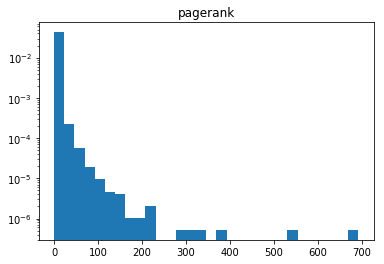

In [44]:
plt.hist(df_pr["pagerank"], density=True, log=True, bins=30)
plt.title("pagerank")
plt.show()

In [37]:
tc = gl.triangle_counting.create(G)

Initializing vertex ids.

Removing duplicate (bidirectional) edges.

Counting triangles...

Finished in 54.4916 secs.

Total triangles in the graph : 53369120

In [38]:
tc_out = tc['triangle_count']

In [55]:
df_tr = pd.merge(df_pr, tc_out.to_dataframe(), how="left", left_on="user_id", right_on="__id", right_index=False)
df_tr = df_tr.drop("__id", axis=1)
df_tr.head()

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean,pagerank,delta,triangle_count
0,1,F,345,6.510145,22.0,5.272727,0.725612,4.440494e-05,1051
1,2,F,97,8.041237,213.0,7.150235,1.779216,5.861817e-06,1057
2,4,F,101,6.841584,1.0,1.000000,0.150254,5.468500e-10,65
3,8,M,21,6.380952,4.0,7.500000,0.156298,5.053215e-08,21
4,9,M,3521,5.856007,22.0,9.454545,0.519412,5.046368e-06,31486


In [56]:
df_tr.sort_values("triangle_count", ascending=False, kind="mergesort").head(10)

,user_id,gender,outdegree,rating_mean,indegree,received_rating_mean,pagerank,delta,triangle_count
55455,90280,F,25042,4.691199,227.0,4.726872,2.066408,0.000006,758033
13725,22319,M,129,8.953488,21387.0,9.923178,390.486254,0.004530,736659
20724,33639,F,19908,4.827758,1220.0,8.188525,18.745023,0.000474,641017
34831,56792,F,21599,6.567989,766.0,7.643603,7.894376,0.000023,610677
52048,84752,F,16667,5.053159,256.0,3.246094,0.920010,0.000009,452765
46675,76082,F,18019,4.682557,175.0,5.228571,1.306238,0.000017,432818
81116,131976,F,17560,5.906435,398.0,7.532663,2.796928,0.000003,427445
78219,127227,F,18342,5.144804,22.0,10.000000,0.594218,0.000003,422555
50513,82272,F,11843,4.951279,1185.0,4.082700,4.939106,0.000030,410156
66541,108318,M,17755,5.279414,487.0,9.936345,1.962708,0.000028,388416


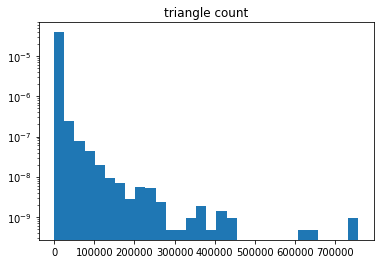

In [45]:
plt.hist(df_tr["triangle_count"], density=True, log=True, bins=30)
plt.title("triangle count")
plt.show()

In [81]:
df_tr["triangle_count"].std()

10613.901148443889

In [ ]:
ax.set_title("{}: received_rating_mean mean={}".format(name, np.round(df['received_rating_mean'].mean(), 1)))

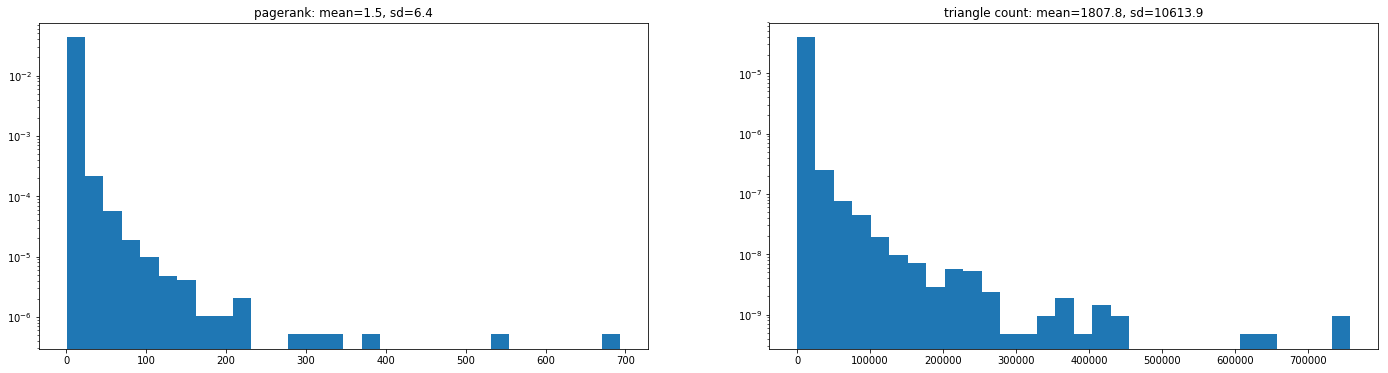

In [82]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)

ax[0].hist(df_tr["pagerank"], density=True, log=True, bins=30)
ax[0].set_title("pagerank: mean={}, sd={}".format(np.round(df_tr['pagerank'].mean(), 1), np.round(df_tr['pagerank'].std(), 1)))
ax[1].hist(df_tr["triangle_count"], density=True, log=True, bins=30)
ax[1].set_title("triangle count: mean={}, sd={}".format(np.round(df_tr['triangle_count'].mean(), 1), np.round(df_tr['triangle_count'].std(), 1)))

plt.show()


In [57]:
X = np.array([
    df_tr['outdegree'],
    df_tr['indegree'],
    df_tr['rating_mean'],
    df_tr['received_rating_mean'],
    df_tr['pagerank'],
    df_tr['triangle_count']
]).T
y = df_stats['gender']

logreg_m2 = sklearn.linear_model.LogisticRegression()
logreg_m2.fit(X, y)

print('Intercept: \n', logreg_m2.intercept_)
print('Coefficients: \n', logreg_m2.coef_)

/Users/teemu/.virtualenvs/graphlab/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/teemu/.virtualenvs/graphlab/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


('Intercept: \n', array([-4.50480564,  4.61463219, -1.17565279]))
('Coefficients: \n', array([[ 3.44782873e-03, -1.60122646e-03,  9.12228165e-01,
        -2.04159107e-01,  1.18951146e-01, -4.98233736e-05],
       [-3.49693446e-03,  1.58495917e-03, -9.27947613e-01,
         2.02880073e-01, -1.18275915e-01,  5.08367551e-05],
       [ 4.84662007e-03, -2.00598036e-02, -7.69520521e-01,
        -4.29258953e-01,  2.36195328e-01, -1.09928837e-03]]))


/Users/teemu/.virtualenvs/graphlab/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [58]:
logreg_m2.score(X, y)

0.7508896369319548